In [37]:
import pandas as pd
import numpy as np
from itertools import product

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift

import matplotlib.pyplot as plt
import seaborn as sns


### 0. Feature Selection
Deciding which features are truly important for the initial clustering and which will either complement the models or be used to evaluate their own density in the final clusters. 

In [3]:
customer_info = pd.read_csv('../data/raw/clean_customer_info.csv', index_col="customer_id")

In [4]:
customer_info.head()

,customer_gender,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,age
customer_id,,,,,,,,,,,,,,,,,,,
29930,-1.0,1.0,1.0,0.0,0.5,-0.603317,0.350843,0.000000,0.299376,0.717154,0.411301,0.716551,0.629503,-0.301504,0.254423,0.467872,0.867906,0.000000,-0.032258
6813,0.0,-1.0,0.0,-1.0,0.5,-0.514208,-2.423571,0.142857,0.354116,-1.414715,-1.445960,-0.272893,-0.466921,-0.438051,-1.433625,-0.486431,-0.384736,2.460565,0.838710
39451,-1.0,1.0,2.0,-1.0,2.0,-0.014666,0.202372,0.142857,0.790758,0.734816,0.740321,0.473346,0.655227,0.343099,0.048656,-0.729704,0.723964,0.000000,-0.612903
21557,0.0,-1.0,-1.0,0.0,-1.0,-0.141192,0.940175,0.142857,-1.730063,-0.495624,0.733403,0.031924,0.061145,-1.395136,0.751694,-0.220805,0.447107,0.048761,-0.193548
16415,0.0,0.0,0.0,0.0,1.0,0.959008,0.042696,0.142857,-0.350786,0.449038,-0.192228,0.090877,0.475513,0.461414,-1.038064,-1.158433,0.521750,0.192977,0.129032


In [5]:
clustering_customer_info = customer_info.drop(columns=[
    'customer_gender',
    'age',
    'percentage_of_products_bought_promotion',
    'typical_hour',
    'distinct_stores_visited',
    'number_complaints'])

Mainly through the PCA, we were able to see these features were not so relevant when it came to explaining the variability on our data. We should, however, save them for later so that we may analyse their density on the clusters.

### 1. Initial Individual Clustering (Baseline Models)

#### 1.1) Hierarchical Clustering
Hierarchical clustering is an unsupervised learning algorithm that groups data points into clusters based on their similarity, building a tree-like structure of joint groups called a dendrogram. Rather than directly partitioning the dataset into a fixed number of clusters (as K-Means does), hierarchical clustering allows the data to self-organize into progressively more refined clusters, revealing the natural structure present in the data. We then manually select how many clusters should be formed by analysing the dendrogram. One should look for a large "jump" in the graph to decide where we want to draw a line that would define how many clusters we'll chose.

#### Hierarchical Clustering: Advantages and Disadvantages

#### Advantages
- Does not require pre-specifying the number of clusters (dendrogram can guide selection).
- Captures nested clustering structure and hierarchical relationships.
- Works well for small to medium-sized datasets.
- Generates a full hierarchy that can be analyzed at multiple levels of granularity.

#### Disadvantages
- Computationally intensive for large datasets.
- Sensitive to noise and outliers, which may distort the hierarchy.
- May struggle to correctly partition datasets with complex or overlapping cluster structures. **This is the case for our dataset**

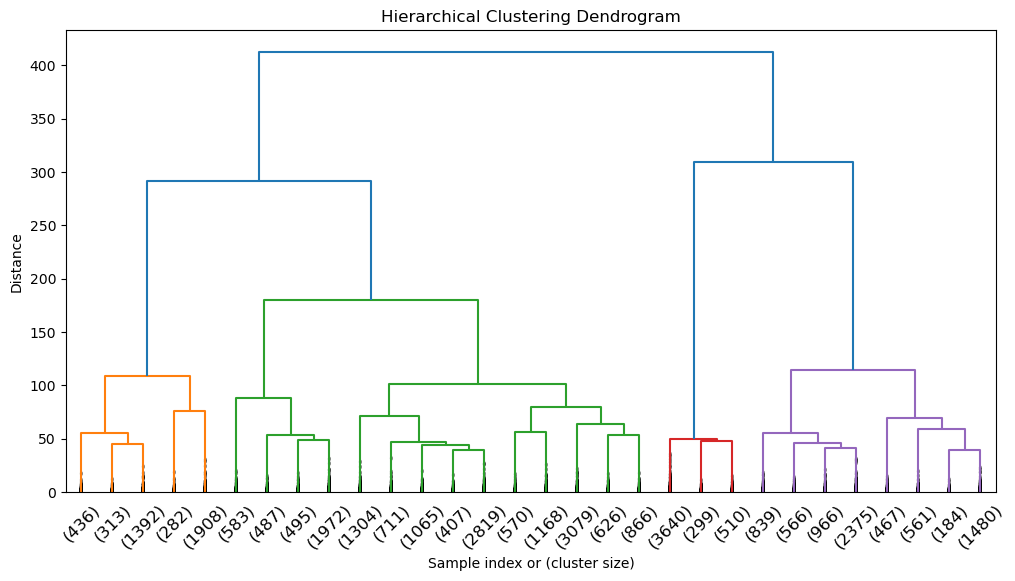

In [6]:
# computing the linkage matrix for dendrogram
linked = linkage(clustering_customer_info, method='ward')  # 'ward' is generally a good default for numeric data

# plotting the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=45., leaf_font_size=12., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.show()


The most appropriate division seems to be at about distance 125, where 5 clusters would be formed.

c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


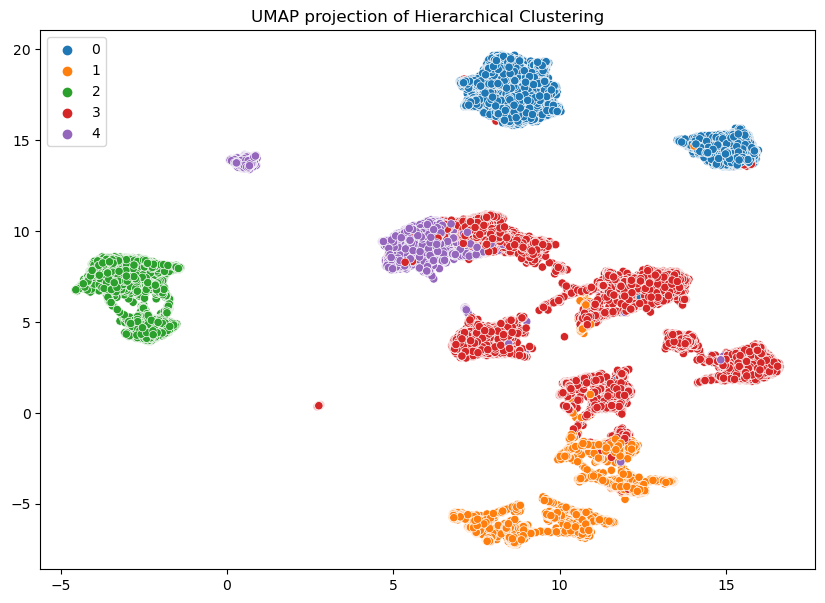

In [7]:
# creating the model
agglo = AgglomerativeClustering(n_clusters=5) 
labels = agglo.fit_predict(clustering_customer_info)

# UMAP visualization
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=labels, palette='tab10')
plt.title("UMAP projection of Hierarchical Clustering")
plt.show()

Not a terrible fit, yet far from good. From simply looking at the data we can see many clusters on the bottom right corner merging with each other, leaving low interpretability. Furthermore, there's a clear lack of granularity on that same side of the UMAP. So, let's retry running the model with higher numbers of clusters and analyse the results.

c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


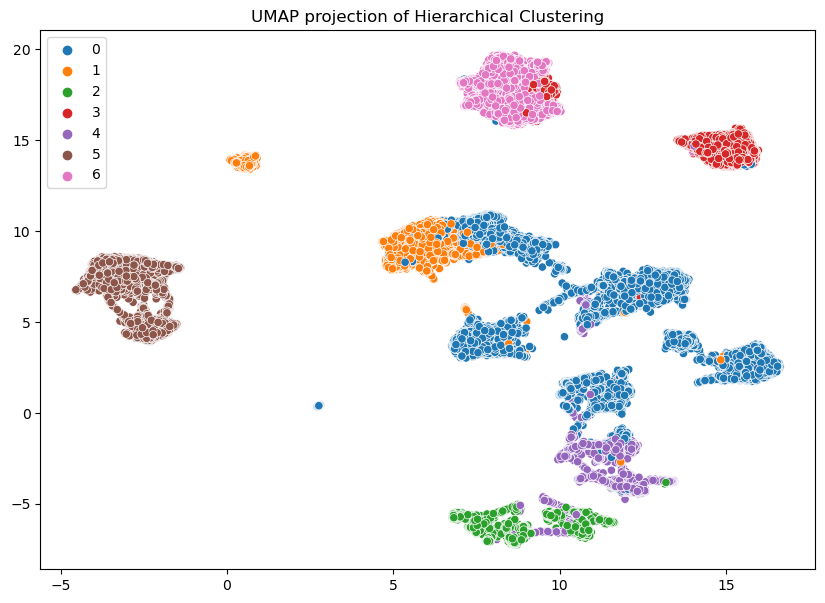

In [8]:
agglo = AgglomerativeClustering(n_clusters=7, linkage='ward')
labels = agglo.fit_predict(clustering_customer_info)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=labels, palette='tab10')
plt.title("UMAP projection of Hierarchical Clustering")
plt.show()

c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


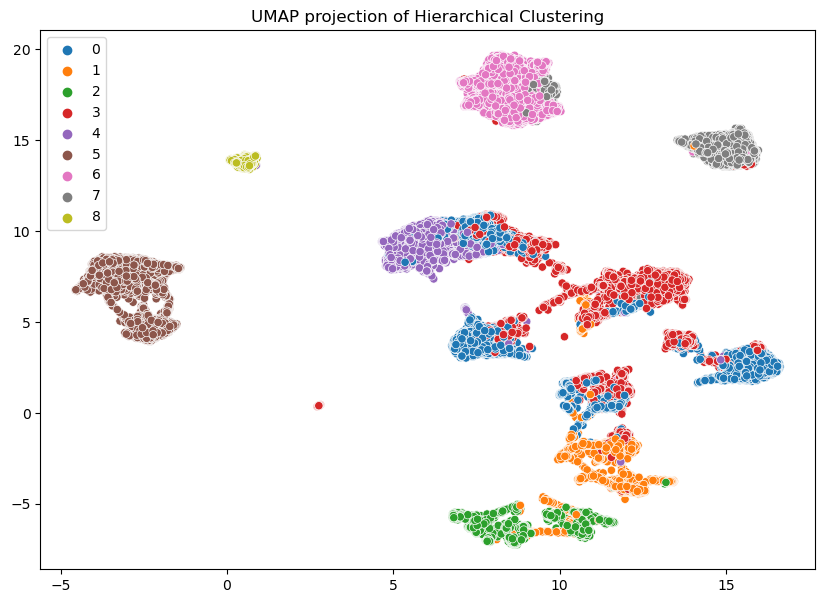

In [9]:
agglo = AgglomerativeClustering(n_clusters=9, linkage='ward')
labels = agglo.fit_predict(clustering_customer_info)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=labels, palette='tab10')
plt.title("UMAP projection of Hierarchical Clustering")
plt.show()

c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


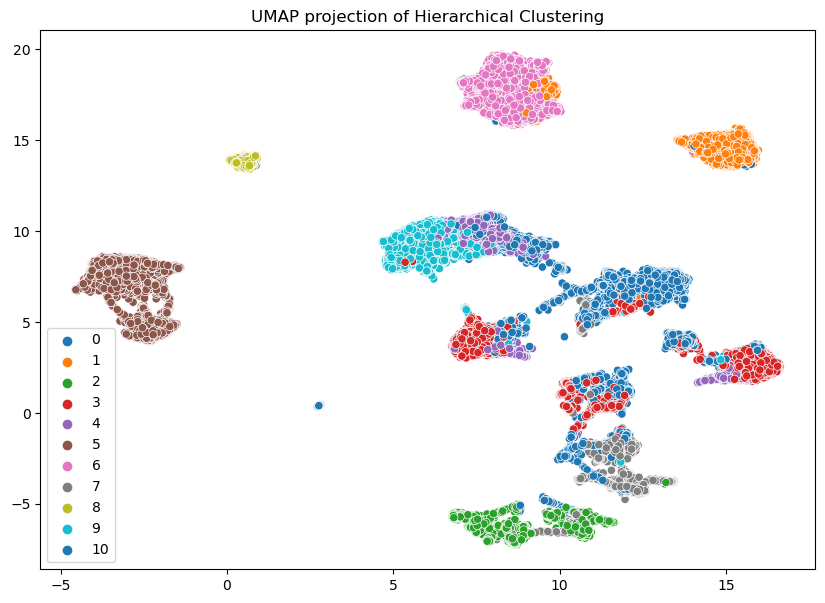

In [10]:
agglo = AgglomerativeClustering(n_clusters=11, linkage='ward')
labels = agglo.fit_predict(clustering_customer_info)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=labels, palette='tab10')
plt.title("UMAP projection of Hierarchical Clustering")
plt.show()

c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


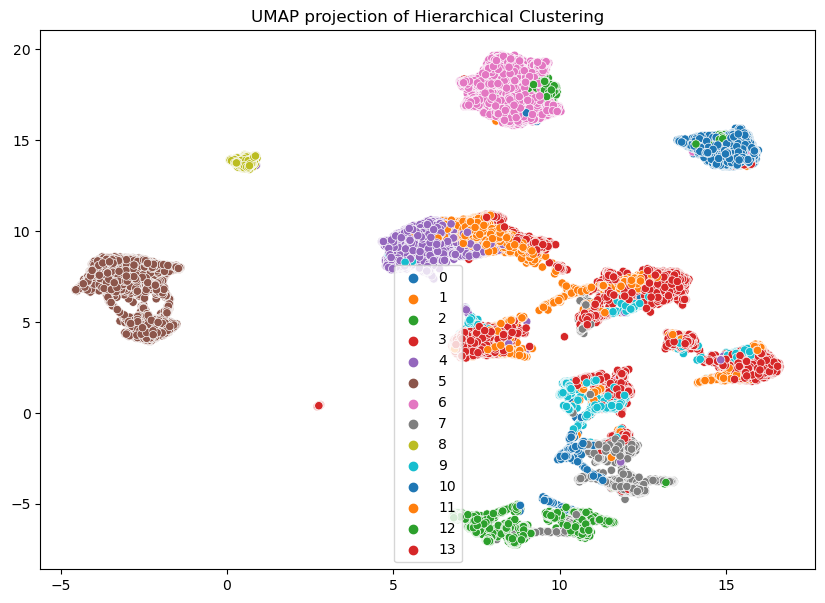

In [11]:
agglo = AgglomerativeClustering(n_clusters=14, linkage='ward')
labels = agglo.fit_predict(clustering_customer_info)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=labels, palette='tab10')
plt.title("UMAP projection of Hierarchical Clustering")
plt.show()

We tested hierarchical clustering with 7, 9, 11, and 14 clusters in order to achieve higher granularity. While increasing the number of clusters allows for finer segmentation, none of the solutions fully captures a clean separation of all groups. The UMAP projections reveal that some clusters remain overlapping or internally heterogeneous across all configurations, suggesting that hierarchical clustering may not be the optimal approach for this dataset.

#### 1.2) K-Means
K-Means divides data into k clusters by minimizing the distance between points and their cluster center. It starts by placing k centroids. Each point is assigned to the nearest centroid. Then, centroids are updated by calculating the average position of all assigned points. This process repeats until centroids stop moving or a maximum number of steps is reached. The goal is to create compact, well-separated groups.

#### K-Means: Advantages and Disadvantages

#### Advantages
- Simple and easy to implement.
- Scales well with the number of observations.
- Works well when clusters are roughly spherical and equally sized.
- Requires few hyperparameters.

#### Disadvantages
- Sensitive to initialization: different runs may yield different results.
- Assumes clusters are spherical and equally sized, struggling with complex shapes. **This is the case for our dataset**
- Sensitive to outliers, which can distort centroids. 

K-Means requires defining the number of clusters k in advance. To help select the optimal k, two metrics are used. The Silhouette Score measures how well-separated and cohesive clusters are, with higher values indicating better structure. The Davies-Bouldin Index compares within-cluster compactness to between-cluster separation, where lower values are preferred. By evaluating both metrics across different values of k, we obtain a more objective basis for choosing the optimal number of clusters.

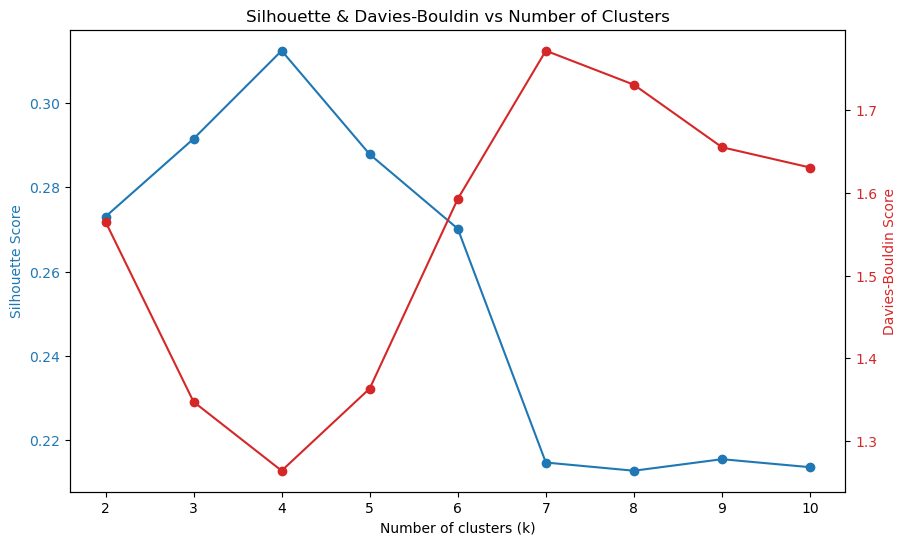

In [12]:
range_n_clusters = range(2, 11)
silhouette_scores = []
davies_bouldin_scores = []

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(clustering_customer_info)
    
    sil_score = silhouette_score(clustering_customer_info, labels)
    db_score = davies_bouldin_score(clustering_customer_info, labels)
    
    silhouette_scores.append(sil_score)
    davies_bouldin_scores.append(db_score)

# plotting both metrics
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Silhouette Score', color=color)
ax1.plot(range_n_clusters, silhouette_scores, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Davies-Bouldin Score', color=color)
ax2.plot(range_n_clusters, davies_bouldin_scores, marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Silhouette & Davies-Bouldin vs Number of Clusters")
plt.show()


For each tested value of k, K-Means assigns points to clusters. After clustering, the Silhouette Score and Davies-Bouldin Index are calculated. The Silhouette Score averages how well each point fits within its cluster versus the next closest cluster. The Davies-Bouldin Index summarizes cluster compactness and separation. The results are plotted, and the optimal k corresponds to high Silhouette values and low Davies-Bouldin values. It is clear that the point where the Silhouette score is highest while the Davies-Bouldin is lowest is at k=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


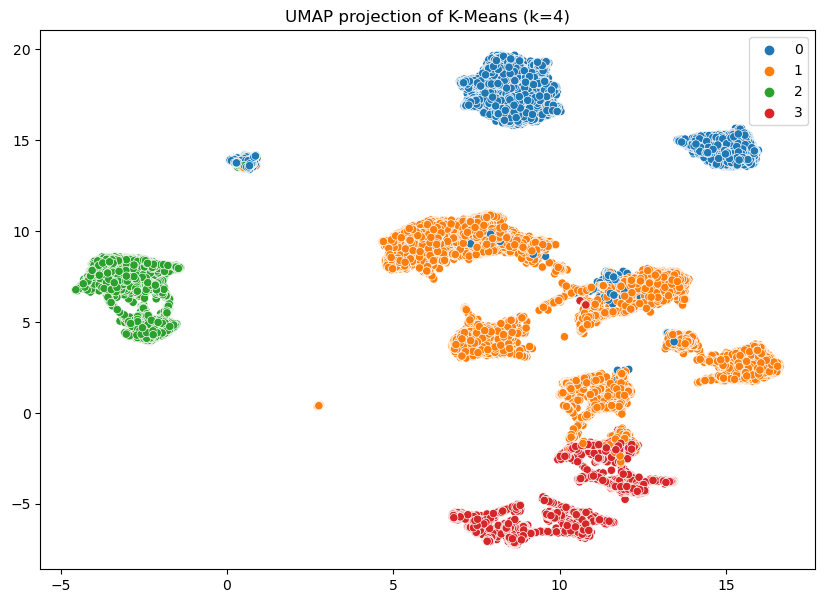

In [13]:
# after inspecting the Silhouette and Davies-Bouldin scores, we can choose the optimal number of clusters.
optimal_k = 4

# fitting the final model
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(clustering_customer_info)

# UMAP visualization
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=labels, palette='tab10')
plt.title(f"UMAP projection of K-Means (k={optimal_k})")
plt.show()

The result with k=4 shows some separation, but one cluster remains large and dispersed, grouping several distinct subgroups. This indicates that the solution lacks granularity and may be oversimplifying the true structure. A higher number of clusters could better capture the internal variability of the data, so let's test that.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


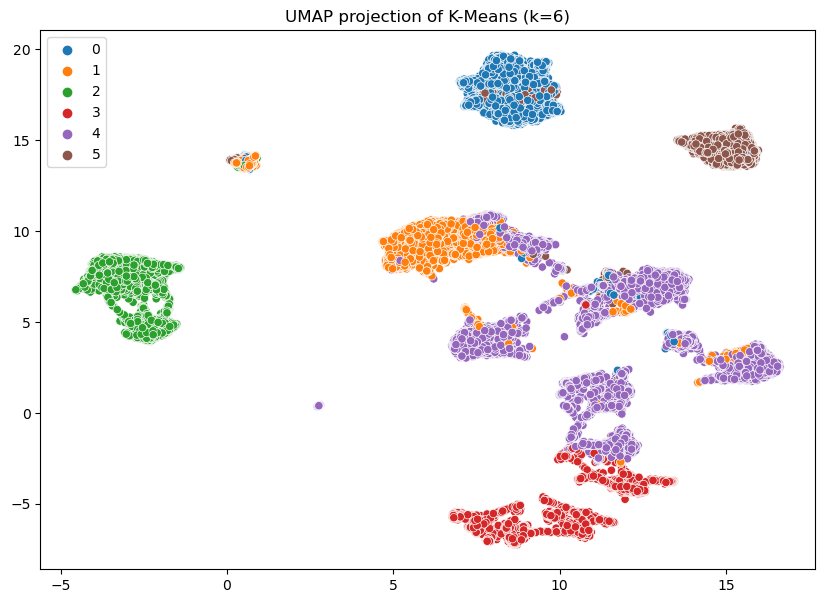

In [14]:
optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(clustering_customer_info)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=labels, palette='tab10')
plt.title(f"UMAP projection of K-Means (k={optimal_k})")
plt.show()

Increasing to k=6 does not improve the segmentation. While some minor subgroups are isolated, the overall structure remains similar and part of the large cluster (on the bottom right corner) is still not well separated.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


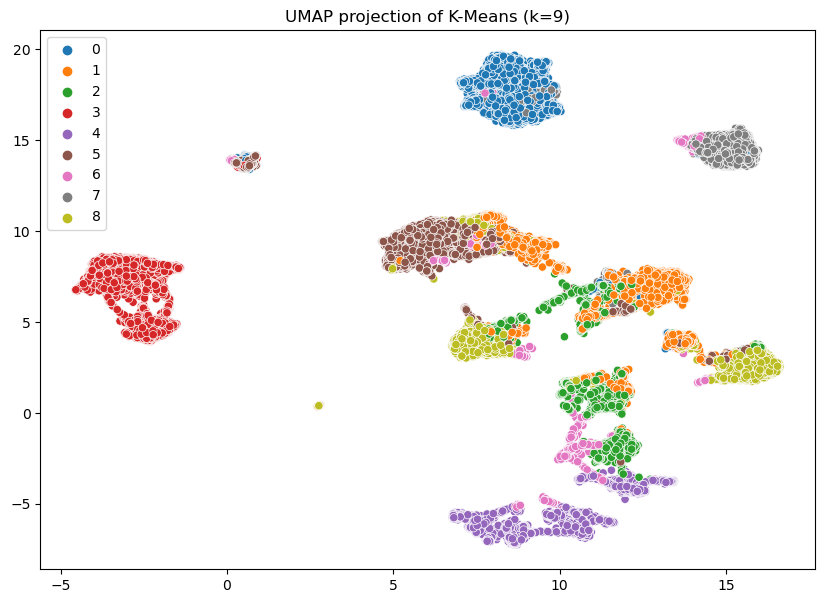

In [15]:
optimal_k = 9

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(clustering_customer_info)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=labels, palette='tab10')
plt.title(f"UMAP projection of K-Means (k={optimal_k})")
plt.show()

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


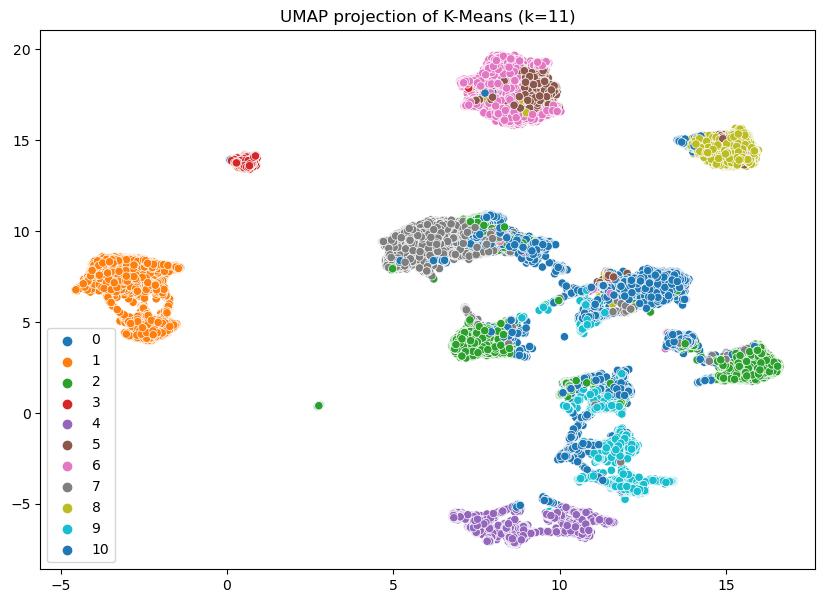

In [16]:
optimal_k = 11

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(clustering_customer_info)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=labels, palette='tab10')
plt.title(f"UMAP projection of K-Means (k={optimal_k})")
plt.show()

Despite testing different values for k, the K-Means algorithm struggled to find well-separated and stable clusters in the data. As k increased, some splits appeared, but the overall structure remained highly mixed, with significant overlap between clusters across the UMAP projection. This can suggest that the underlying data may not exhibit strong natural partitions suitable for K-Means.

#### 1.3) K-Medoids
K-Medoids is a clustering algorithm that groups data based on similarity, like K-Means, but with a big difference: rather than calculating the average position of points (centroid), K-Medoids selects actual data points as cluster centers (medoids). A medoid is the most central point in a cluster, having the smallest total distance to all other points within that cluster. By using real data points as centers, K-Medoids is more robust to outliers and extreme values.

#### K-Medoids: Advantages and Disadvantages

#### Advantages
- More robust to noise and outliers compared to K-Means, since it uses actual data points as cluster centers.
- Handles non-spherical and unevenly sized clusters better than K-Means in some cases.
- Guarantees that cluster centers are always valid data points, which can simplify interpretation.

#### Disadvantages
- Computationally more expensive than K-Means, especially on large datasets. **This is the case for our dataset as well as the reason why we won't be using this algorithm**
- Still requires specifying the number of clusters k in advance.
- May struggle with very high-dimensional data, like most distance-based algorithms.

#### 1.4) Self-Organizing Map (SOM)
Self-Organizing Maps (SOM) are unsupervised neural networks that turn complex data into a two-dimensional grid where similar points are placed close together. As data is processed, the algorithm finds the closest neuron for each point and adjusts it, along with its neighbors, to better match the data. After many repetitions, the map organizes itself to reveal natural groupings in the data.

#### Self-Organizing Maps (SOM): Advantages and Disadvantages

#### Advantages
- Useful for visualizing high-dimensional data in 2D.
- Can reveal clusters and patterns that are hard to detect with other methods.
- Handles non-linear relationships well.

#### Disadvantages
- Requires careful tuning of hyperparameters (grid size, learning rate, neighborhood function).
- Computationally expensive for large datasets.
- Interpretation of the map may not always be straightforward.
- No clear objective function like K-Means (harder to evaluate quality quantitatively).


##### About the parameters
When we **increase the grid size**, we allow the map to form more detailed and fine-grained clusters, potentially capturing subtle distinctions between customer groups. However, if the grid becomes too large relative to the data size, it may create many small or empty clusters, making interpretation harder. **Increasing the learning rate** causes the neurons to adapt more quickly at each iteration, which may speed up convergence but risks making the learning process unstable and overshooting good solutions. **Lowering the learning rate** leads to a more gradual and stable adjustment of neurons but requires more iterations to fully converge. The sigma parameter controls the neighborhood radius, determining how far around the best matching neuron the updates will affect other neurons. **A higher sigma** results in smoother, more generalized mappings where larger regions of the map are adjusted together, possibly blurring smaller patterns. **A lower sigma** sharpens the distinctions between clusters but may create fragmented or noisy maps if set too small. All three parameters interact, and tuning them balances between capturing meaningful structure and avoiding overfitting to noise.

In [17]:
import numpy as np
from minisom import MiniSom
from sklearn.metrics import silhouette_score
from itertools import product


som_array = clustering_customer_info.to_numpy() 

# defining candidate values
grid_sizes = [3, 4] # defining grid sizes according to the number of clusters we want to find (less clusters imply a smaller grid size) (doesn't make sense to use a 2x2 grid as it would only find, at max , 4 clusters)
learning_rates = [0.1, 0,2, 0.3]  # learning rates for the SOM
sigmas = [1.0, 1.5, 2.0] 

# storing results
results = []

for grid_size, lr, sigma in product(grid_sizes, learning_rates, sigmas): 
    som = MiniSom(x=grid_size, y=grid_size, input_len=som_array.shape[1], sigma=sigma, learning_rate=lr)
    som.random_weights_init(som_array)
    som.train(som_array, 5000, verbose=False)
    
    # Silhouette score (use only if you have >1 cluster)
    if len(set(labels)) > 1:
        score = silhouette_score(som_array, labels)
    else:
        score = -1
    
    results.append((grid_size, lr, sigma, score))

# sorting the results by silhouette score descending (reverse=True)
results.sort(key=lambda x: x[3], reverse=True)

# print out the best 5 parameter combinations
for res in results[:5]:
    print(f"Grid: {res[0]}x{res[0]}, Learning rate: {res[1]}, Sigma: {res[2]}, Silhouette: {res[3]:.4f}")


Grid: 3x3, Learning rate: 0.1, Sigma: 1.0, Silhouette: 0.2145
Grid: 3x3, Learning rate: 0.1, Sigma: 1.5, Silhouette: 0.2145
Grid: 3x3, Learning rate: 0.1, Sigma: 2.0, Silhouette: 0.2145
Grid: 3x3, Learning rate: 0, Sigma: 1.0, Silhouette: 0.2145
Grid: 3x3, Learning rate: 0, Sigma: 1.5, Silhouette: 0.2145


To evaluate and compare the different parameter combinations of the SOM, the Silhouette score was used as a rough indicator of cluster quality. While not perfect for topology-based algorithms like SOM, it provides a simple way to assess how well the data points assigned to each neuron are grouped together, helping to discard parameter settings that produce poorly separated or unstable mappings. 

c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


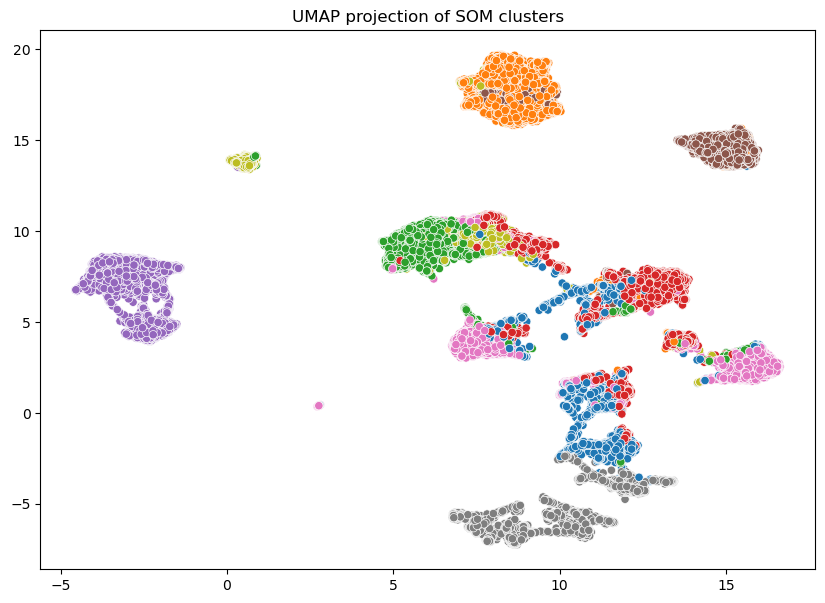

In [25]:
# Initialize SOM with the previously determined best parameters
som = MiniSom(x=3, y=3, input_len=som_array.shape[1], sigma=1, learning_rate=0.1)
som.random_weights_init(som_array)
som.train(som_array, 5000, verbose=False)

# assigning each point to its BMU (the neuron on the SOM grid whose weight vector is most similar to the input data point.)
bmus = np.array([som.winner(x) for x in som_array]) # Getting the BMUs allows you to assign each customer to its cluster, based on where it landed on the SOM grid.
labels = [str(bmu[0]) + "_" + str(bmu[1]) for bmu in bmus]

# UMAP visualization
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(som_array)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette='tab10', legend=None)
plt.title("UMAP projection of SOM clusters")
plt.show()


Even though we carefully tuned the SOM parameters to values well-suited for the dataset, the resulting clusters still show considerable overlap and dispersion in the UMAP projection. This suggests that, given the underlying structure of the data, the SOM algorithm struggled to find clearly separated and stable segments.

#### 1.5) Density-Based Spatial Clustering of Applications with Noise (DBSCAN)
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) groups data based on density. It identifies core points that have enough nearby neighbours, and expands clusters by connecting points that are within the range defined by eps. DBSCAN does not require specifying the number of clusters in advance, but it is rather sensitive to the choice of eps and min_samples.

#### DBSCAN: Advantages and Disadvantages

### Advantages
- Does not require specifying the number of clusters beforehand.
- Effectively detects noise and outliers.

### Disadvantages
- Sensitive to the choice of `eps` and `min_samples`.
- Struggles with varying densities across clusters. **This is the case for our dataset**
- Difficult to interpret and tune for complex datasets.

We will firstly look at different combinations of the eps with min samples.

In [30]:
for mp in range(10, 71, 30):
    for eps_ in [1.7,2,2.5,3]:
        db = DBSCAN(eps=eps_, min_samples=mp)
        db.fit(clustering_customer_info)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_outliers = list(labels).count(-1)

        if n_clusters > 5: # as we've clearly seen from our data, there are over 5 clusters
            print(eps_, mp, n_clusters, n_outliers)

1.7 10 9 0
2 10 9 0
2.5 10 9 0
3 10 9 0
1.7 40 9 0
2 40 9 0
2.5 40 9 0
3 40 9 0
1.7 70 9 0
2 70 9 0
2.5 70 9 0
3 70 9 0


We tested multiple combinations of eps and min_samples for DBSCAN. In all cases, the algorithm consistently found 9 clusters with no outliers, suggesting the transformations applied in the preprocessing were successful. The clustering results showed little sensitivity to the parameter values within the tested ranges. Let us now visualize our results through a UMAP representation of our data.

c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


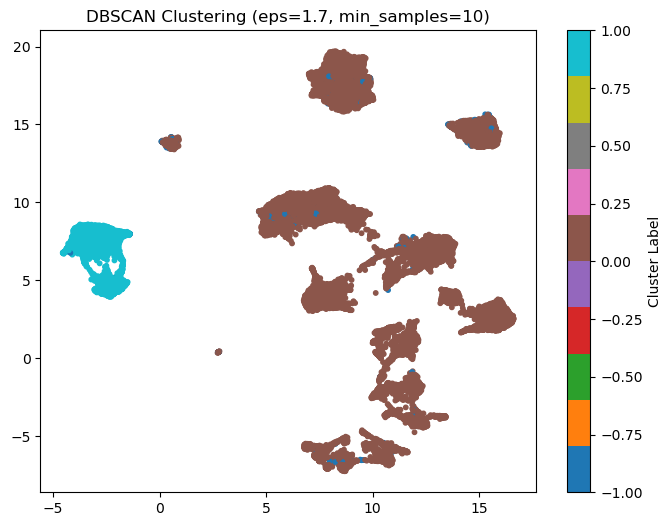

In [ ]:
# our chosen parameters
eps_chosen = 1.7
min_samples_chosen = 10

# fitting DBSCAN
db = DBSCAN(eps=eps_chosen, min_samples=min_samples_chosen)
db.fit(clustering_customer_info)

labels = db.labels_

# creating the UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(8,6))
scatter = plt.scatter(embedding[:,0], embedding[:,1], c=labels, cmap='tab10', s=10)
plt.title(f'DBSCAN Clustering (eps={eps_chosen}, min_samples={min_samples_chosen})')
plt.colorbar(scatter, label='Cluster Label')
plt.show()


c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


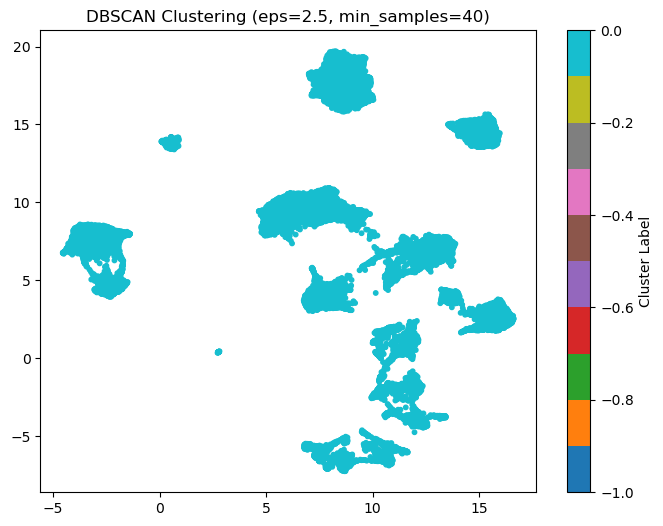

In [ ]:
# our chosen parameters
eps_chosen = 2.5
min_samples_chosen = 40

# fitting DBSCAN
db = DBSCAN(eps=eps_chosen, min_samples=min_samples_chosen)
db.fit(clustering_customer_info)

labels = db.labels_

# creating the UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(8,6))
scatter = plt.scatter(embedding[:,0], embedding[:,1], c=labels, cmap='tab10', s=10)
plt.title(f'DBSCAN Clustering (eps={eps_chosen}, min_samples={min_samples_chosen})')
plt.colorbar(scatter, label='Cluster Label')
plt.show()


c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


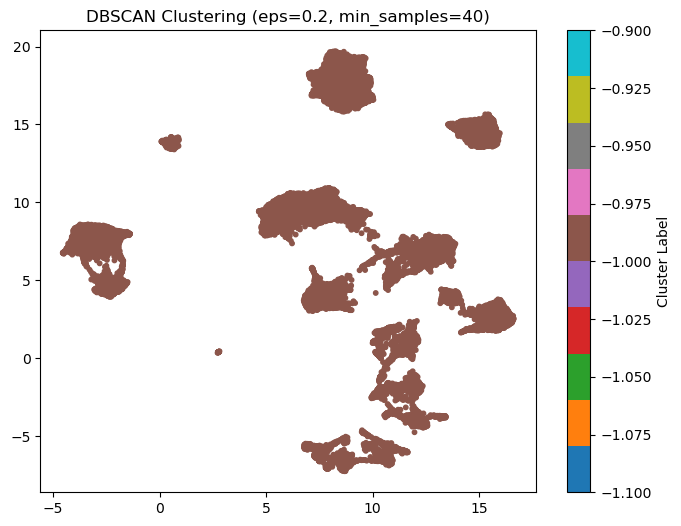

In [ ]:
# our chosen parameters
eps_chosen = 0.2
min_samples_chosen = 40

# fitting DBSCAN
db = DBSCAN(eps=eps_chosen, min_samples=min_samples_chosen)
db.fit(clustering_customer_info)

labels = db.labels_

# creating the UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(8,6))
scatter = plt.scatter(embedding[:,0], embedding[:,1], c=labels, cmap='tab10', s=10)
plt.title(f'DBSCAN Clustering (eps={eps_chosen}, min_samples={min_samples_chosen})')
plt.colorbar(scatter, label='Cluster Label')
plt.show()


c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


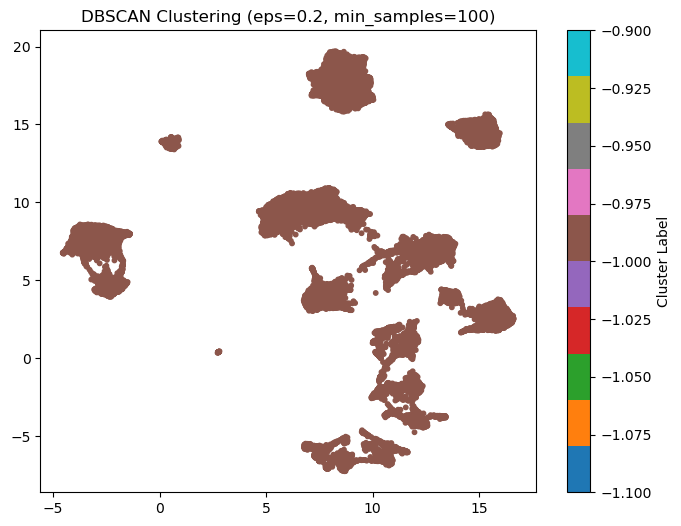

In [ ]:
# our chosen parameters
eps_chosen = 0.2
min_samples_chosen = 100

# fitting DBSCAN
db = DBSCAN(eps=eps_chosen, min_samples=min_samples_chosen)
db.fit(clustering_customer_info)

labels = db.labels_

# creating the UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(8,6))
scatter = plt.scatter(embedding[:,0], embedding[:,1], c=labels, cmap='tab10', s=10)
plt.title(f'DBSCAN Clustering (eps={eps_chosen}, min_samples={min_samples_chosen})')
plt.colorbar(scatter, label='Cluster Label')
plt.show()


Despite testing several combinations of eps and min_samples, DBSCAN was not able to produce a stable or meaningful clustering solution. Small changes in the parameters either led to most data being classified as noise or grouped nearly everything into a single cluster. This suggests that the data structure may not be well-suited for density-based clustering with DBSCAN, as no clear density separation could be consistently captured.

#### 1.6) Mean-Shift
Mean Shift is a clustering algorithm that works by iteratively shifting data points towards the densest areas of the dataset. For each point, it defines a window around it and computes the mean of all data points within this window. The center of the window is then moved to this mean, and the process repeats until convergence (the points stop moving significantly). As points converge to common locations, these locations are identified as cluster centers.

#### Mean-Shift: Advantages and Disadvantages

#### Advantages
- Does not require specifying the number of clusters beforehand.
- Can find clusters of arbitrary shape and size.
- Conceptually simple and intuitive.

#### Disadvantages
- Sensitive to bandwidth selection, which can be difficult to tune.
- Struggles with clusters of very different densities or sizes.
- Poor scalability to high-dimensional data.

Our strategy for finding the ideal bandwidth will be trial and error.

c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


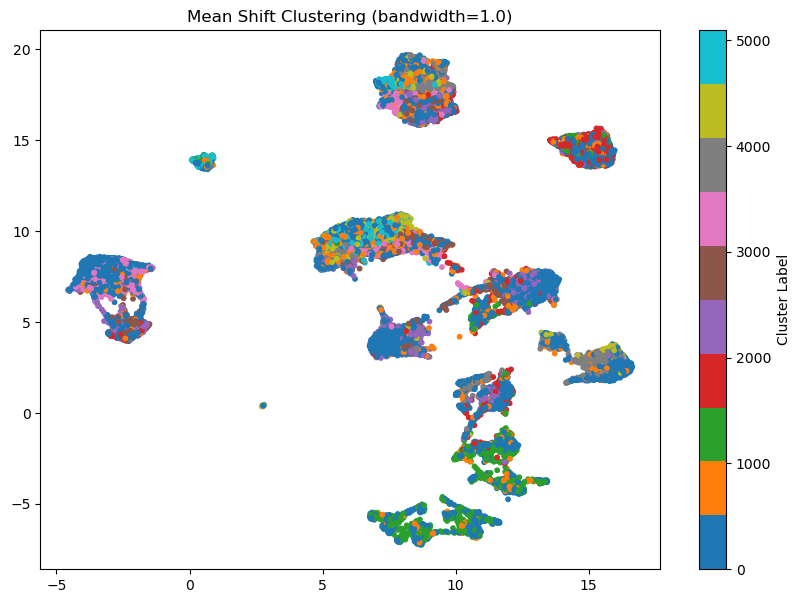

In [42]:
bandwidth = 1.0 
ms = MeanShift(bandwidth=bandwidth, n_jobs=-1, bin_seeding=True)
ms.fit(clustering_customer_info)

labels = ms.labels_

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(10, 7))
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=10)
plt.title(f"Mean Shift Clustering (bandwidth={bandwidth})")
plt.colorbar(label="Cluster Label")
plt.show()


In Mean Shift, bandwidth controls how far the algorithm looks for dense regions. If the bandwidth is too small, it creates many small, fragmented clusters by treating minor variations as distinct groups. Increasing the bandwidth merges nearby clusters into more meaningful structures. If the bandwidth is too large, distinct groups get merged into overly broad clusters, as it happens here. Decreasing the bandwidth in this case helps recover finer distinctions.

c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


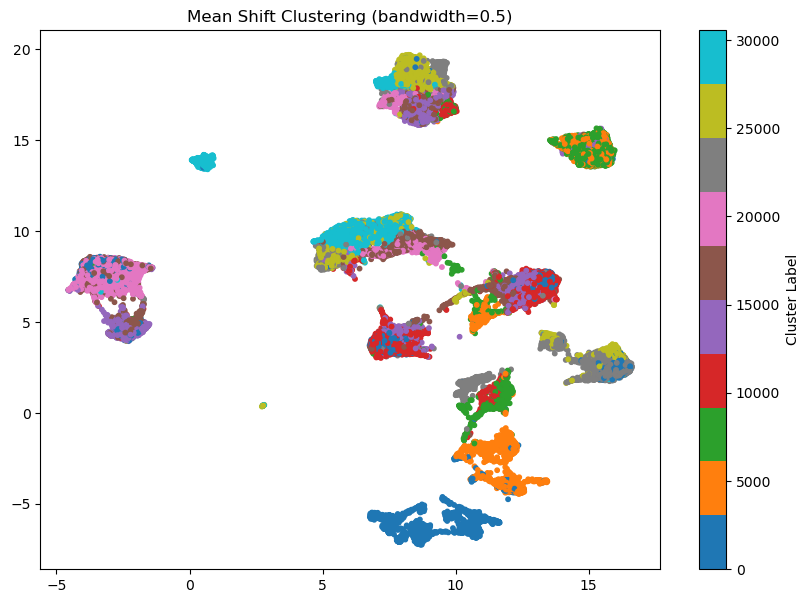

In [44]:
bandwidth = 0.5 
ms = MeanShift(bandwidth=bandwidth)
ms.fit(clustering_customer_info)

labels = ms.labels_

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(10, 7))
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=10)
plt.title(f"Mean Shift Clustering (bandwidth={bandwidth})")
plt.colorbar(label="Cluster Label")
plt.show()

c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


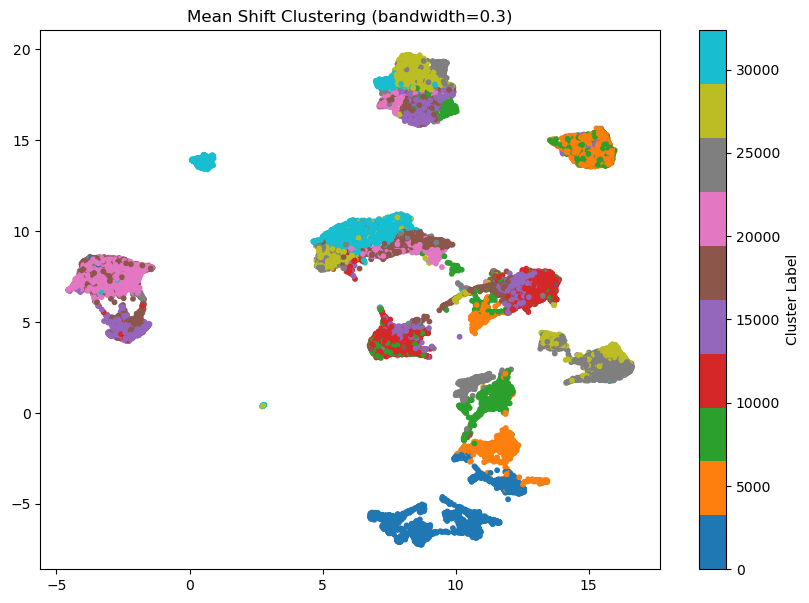

In [ ]:
bandwidth = 0.3
ms = MeanShift(bandwidth=bandwidth)
ms.fit(clustering_customer_info)

labels = ms.labels_

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(10, 7))
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=10)
plt.title(f"Mean Shift Clustering (bandwidth={bandwidth})")
plt.colorbar(label="Cluster Label")
plt.show()

c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


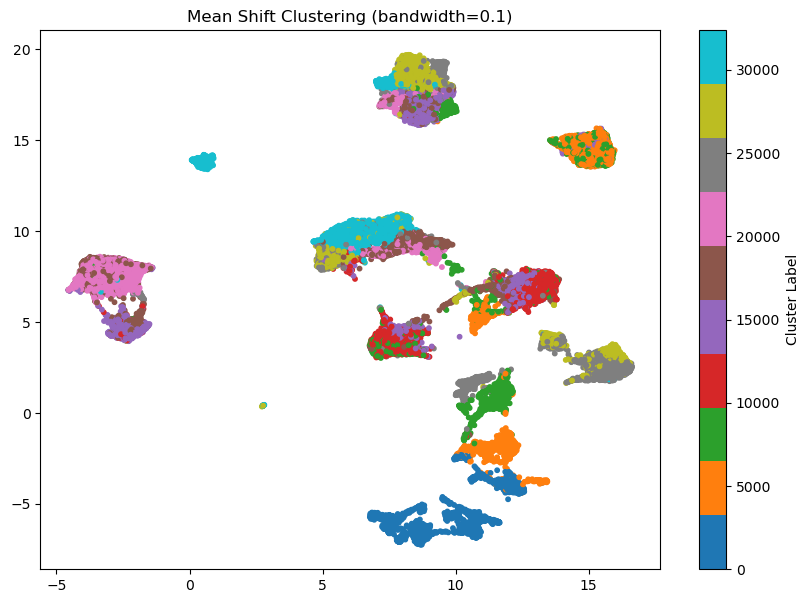

In [45]:
bandwidth = 0.1
ms = MeanShift(bandwidth=bandwidth)
ms.fit(clustering_customer_info)

labels = ms.labels_

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(10, 7))
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=10)
plt.title(f"Mean Shift Clustering (bandwidth={bandwidth})")
plt.colorbar(label="Cluster Label")
plt.show()

Despite testing a range of bandwidth values, Mean Shift was not able to properly capture the underlying cluster structure of the dataset. At lower bandwidths, the algorithm over-fragmented the data into an excessive number of tiny clusters, while higher bandwidths quickly led to excessive merging without producing meaningful segmentation. This suggests that Mean Shift struggles to adapt to the complex density distribution of our data.

### 2. Tandem Approaches (Two-Step Clustering)

#### 2.1) Hierarchical + K-Means

#### 2.2) K-Means (large k) + Hierarchical

### 3. Comparison, Profiling and Selection